## Tree Density Analysis

In [165]:
# Packages
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import censusdata
import re
import numpy as np
import os


In [166]:
# Reading in shapefiles
trees_path = Path(r"C:\\Users\\Jena-\\syracusetrees\\shapefiles\\Syracuse_Tree_Data\\Syracuse_Tree_Data.shp")
tracts_path = Path(r"C:\\Users\\Jena-\\syracusetrees\\shapefiles\\Census_Tracts_in_Syracuse_NY\\Census_Tracts_in_Syracuse_NY_-_2020.shp")

trees = gpd.read_file(trees_path)
tracts = gpd.read_file(tracts_path)
tracts = tracts.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

In [167]:
# Spatial Join
tree_tract = gpd.sjoin(trees, tracts, how="inner", predicate="intersects")

In [168]:
# Calculating area and density
trees_per_tract = tree_tract.groupby('TRACTCE20').size().reset_index(name='tree_count')
tracts_with_counts = tracts.merge(trees_per_tract, on='TRACTCE20', how='left')
tracts_with_counts['tree_count'] = tracts_with_counts['tree_count'].fillna(0)
tracts_with_counts['area_km2'] = tracts_with_counts.geometry.area / 10**6
tracts_with_counts['tree_density'] = tracts_with_counts['tree_count'] / tracts_with_counts['area_km2']


(np.float64(401407.6255835014),
 np.float64(413018.2834264848),
 np.float64(4759148.403513772),
 np.float64(4771598.94972032))

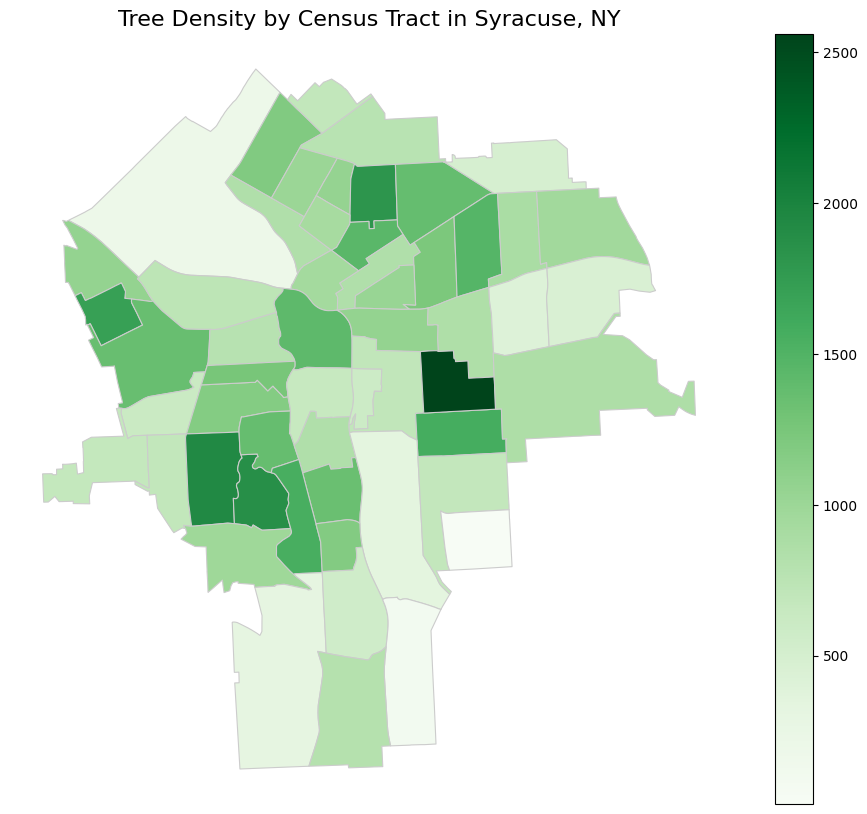

In [169]:
# Plot density
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
tracts_with_counts.plot(
    column='tree_density',
    cmap='Greens',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,           
    ax=ax
)
ax.set_title('Tree Density by Census Tract in Syracuse, NY', fontsize=16)
ax.axis('off')


In [ ]:
state_fips = '36'  
county_fips = '067' 

income_data = censusdata.download(
    'acs5',             
    2022,                 
    censusdata.censusgeo([('state', state_fips), ('county', county_fips), ('tract', '*')]),
    ['B19013_001E']     



In [172]:
# Cleaning that to merge
income_data['census_tract'] = income_data['census_tract'].astype(float)
income_data['census_tract'] = income_data['census_tract'].apply(lambda x: f"{int(x*100):06d}")

income_data_geo = tracts.merge(
    income_data[['census_tract', 'B19013_001E']],
    left_on='TRACTCE20',
    right_on='census_tract',
    how='left'
)

KeyError: 'census_tract'

In [ ]:
# First merge trees with income
tracts_full = tracts_with_counts.merge(
    income_data[['census_tract', 'B19013_001E']],
    left_on='TRACTCE20',
    right_on='census_tract',
    how='left'
)


KeyError: "['census_tract'] not in index"

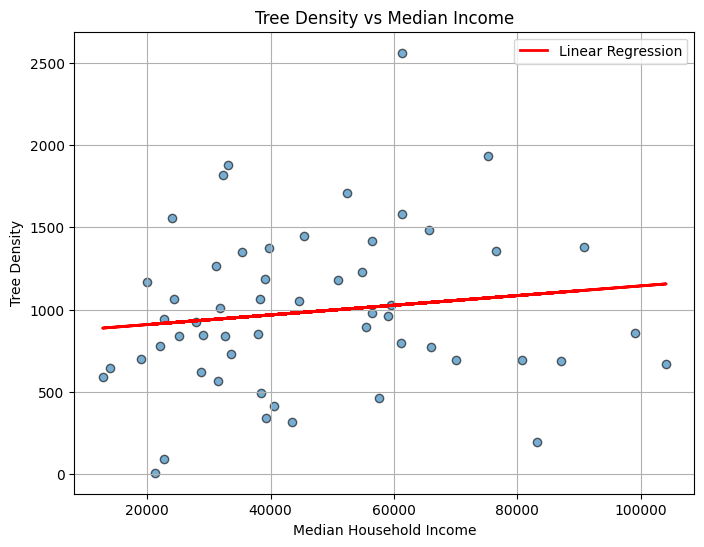

In [ ]:
# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(tracts_full['B19013_001E'], tracts_full['tree_density'], alpha=0.6, edgecolor='k')

x = tracts_full['B19013_001E']
y = tracts_full['tree_density']
m, b = np.polyfit(x, y, 1) 

plt.plot(x, m*x + b, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('Median Household Income')
plt.ylabel('Tree Density')
plt.title('Tree Density vs Median Income')
plt.grid(True)
plt.legend()
plt.show()

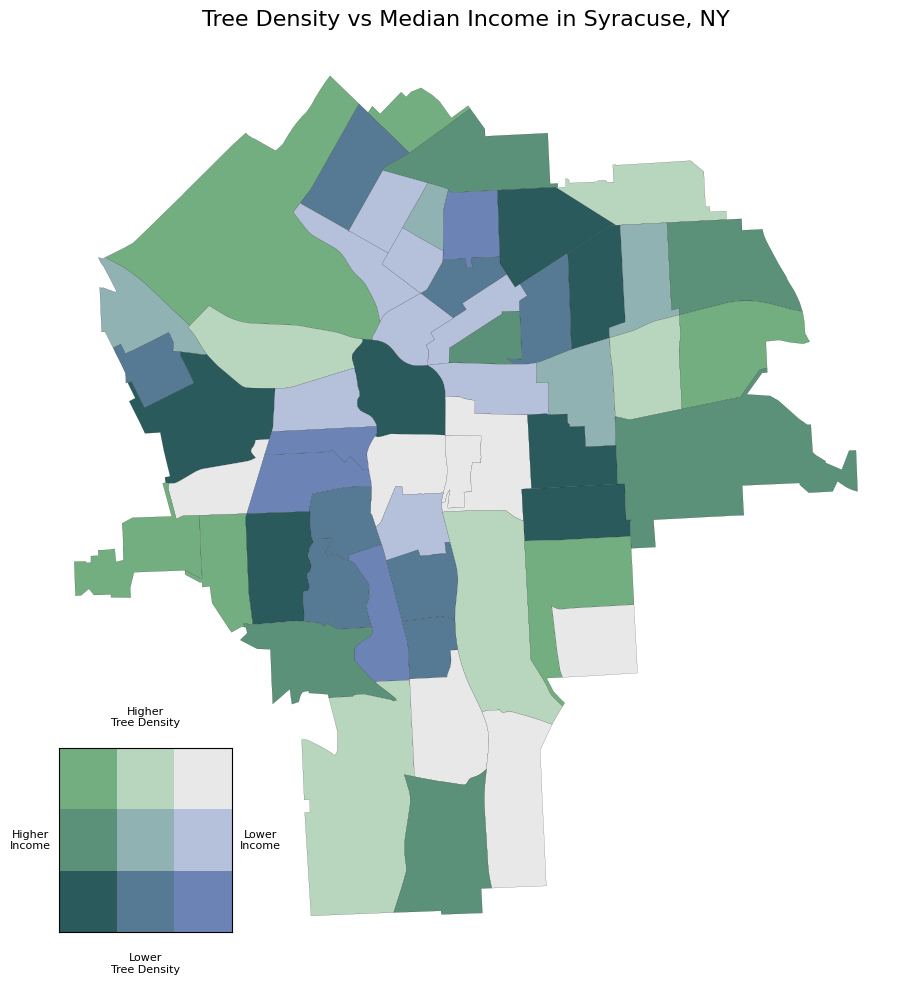

In [ ]:
# Comparison Map
tracts_full['income_quantile'] = pd.qcut(tracts_full['B19013_001E'], q=3, labels=[1,2,3])
tracts_full['tree_quantile'] = pd.qcut(tracts_full['tree_density'], q=3, labels=[1,2,3])
tracts_full['bivariate_class'] = tracts_full['income_quantile'].astype(str) + "-" + tracts_full['tree_quantile'].astype(str)

# 1 - 1 is low income high trees, 3 - 3 is high income high trees
bivariate_colors = {
    '1-1': '#e8e8e8', 
    '1-2': '#b5c0da',
    '1-3': '#6c83b5',
    '2-1': '#b8d6be',
    '2-2': '#90b2b3',
    '2-3': '#567994',
    '3-1': '#73ae80',
    '3-2': '#5a9178',
    '3-3': '#2a5a5b'
}
tracts_full['color'] = tracts_full['bivariate_class'].map(bivariate_colors)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
tracts_full.plot(
    color=tracts_full['color'],
    linewidth=0.1,
    ax=ax,
    edgecolor='black'
)

# Legend and stuff 
ax.set_title('Tree Density vs Median Income in Syracuse, NY', fontsize=16)
ax.axis('off')
legend_colors = np.array([
    [bivariate_colors['3-3'], bivariate_colors['2-3'], bivariate_colors['1-3']],
    [bivariate_colors['3-2'], bivariate_colors['2-2'], bivariate_colors['1-2']],
    [bivariate_colors['3-1'], bivariate_colors['2-1'], bivariate_colors['1-1']]
])
axins = inset_axes(ax, width="20%", height="20%", loc='lower left',
                   bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes)

# Plot squares for legend
for x in range(3):
    for y in range(3):
        rect = mpatches.Rectangle((x, y), 1, 1, facecolor=legend_colors[y, x])
        axins.add_patch(rect)
axins.set_xlim(0, 3)
axins.set_ylim(0, 3)
axins.set_xticks([])
axins.set_yticks([])
axins.text(-0.5, 1.5, 'Higher\nIncome', va='center', ha='center', fontsize=8)
axins.text(3.5, 1.5, 'Lower\nIncome', va='center', ha='center', fontsize=8)
axins.text(1.5, 3.5, 'Higher\nTree Density', va='center', ha='center', fontsize=8)
axins.text(1.5, -0.5, 'Lower\nTree Density', va='center', ha='center', fontsize=8)

plt.show()

Sources: 
United States Census Bureau 
https://data-syr.opendata.arcgis.com/
https://github.com/mikhailsirenko/bivariate-choropleth 